In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [5]:
merge_all_flatten = pd.read_csv('./merge_all_flatten.csv')

In [6]:
label_dir ='C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_label_add.csv'

train_label = pd.read_csv(label_dir)
del train_label['Unnamed: 0']

In [7]:
merge_all_flatten.shape

(40000, 401)

In [8]:
merge_all = pd.merge(merge_all_flatten, train_label, on='acc_id')

In [9]:
merge_all.shape

(40000, 405)

In [10]:
# label로 인해 payment의 amount_spent에 _x가 추가됨
# 실제로 leaderboard에 올릴 때에는 label을 합치지 않으므로 _x가 붙을일이 없음
# 따라서 rename을 해줌
merge_all.rename(columns = {'amount_spent_x':'amount_spent'}, inplace = True)

In [34]:
merge_all_flatten.head()

,acc_id,temp_cnt_x,private_shop,level_x,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,...,random_defender_cnt_4_y,same_pledge_cnt_4_y,temp_cnt_4_y,etc_cnt_4_y,combat_play_time_4,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4
0,2,0.000000,84.900753,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,5,0.479728,0.000000,173.0,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.715313,0.000000,1.384363,0.417618,3.661882,66814.0,0.000000,0.000000,0.000000,0.000000
2,8,3.837822,0.000000,1922.0,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,...,4.077286,4.774303,21.556504,6.243030,29.782361,22331.0,1.056123,0.000000,0.000000,0.348521
3,17,3.358094,0.000000,687.0,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,...,1.859815,0.000000,10.778252,2.526941,15.140507,2673.0,0.000000,0.000000,0.000000,0.000000
4,20,0.959456,2.917510,930.0,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,...,2.360534,3.978586,7.317346,11.672059,18.448062,2500.0,0.000000,0.070408,0.826123,0.000000


In [53]:
merge_all_flatten.shape, merge_standard.shape

((40000, 401), (40000, 405))

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(merge_all_flatten.drop('acc_id',axis=1))
merge_all_flatten_standard = scaler.transform(merge_all_flatten.drop('acc_id', axis=1))

In [12]:
merge_standard = pd.DataFrame(merge_all_flatten_standard)
merge_standard.index = merge_all_flatten.acc_id
merge_standard.reset_index(inplace=True)
merge_standard.columns = merge_all_flatten.columns
merge_standard = pd.merge(merge_standard, train_label, on='acc_id')

In [280]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(merge_all_flatten.drop('acc_id',axis=1))
merge_all_flatten_minmax = scaler.transform(merge_all_flatten.drop('acc_id',axis=1))

In [281]:
merge_minmax = pd.DataFrame(merge_all_flatten_minmax)
merge_minmax.index = merge_all_flatten.acc_id
merge_minmax.reset_index(inplace=True)
merge_minmax.columns = merge_all_flatten.columns
merge_minmax = pd.merge(merge_minmax, train_label, on='acc_id')

In [297]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_standard.drop(['acc_id', 
                                                                           'amount_spent_y',
                                                                           'total_spent',
                                                                          'secession',
                                                                          'survival_time'], axis=1),
                                                    merge_standard.secession,
                                                    test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 400), (7000, 400), (12000, 400), (21000,), (7000,), (12000,))

In [294]:
import tensorflow as tf
from keras import models
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization

np.random.seed(42)
tf.random.set_random_seed(42)

X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train).reshape(-1,1)

X_valid_arr = np.array(X_valid)
y_valid_arr = np.array(y_valid).reshape(-1,1)

# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = Sequential()
model.add(Dense(64, activation = 'selu', kernel_initializer='lecun_uniform', input_shape=(400,)))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'selu', kernel_initializer='lecun_uniform'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'selu', kernel_initializer='lecun_uniform'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu', kernel_initializer='lecun_normal'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu', kernel_initializer='lecun_normal'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu', kernel_initializer='lecun_normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(optimizer = 'adadelta',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(X_train,
                   y_train,
                   epochs = 20,
                   batch_size = 1000,
                   validation_data = (X_valid, y_valid))

Train on 21000 samples, validate on 7000 samples
Epoch 1/20
21000/21000 [==============================] - 15s 734us/step - loss: 0.8310 - acc: 0.6132 - val_loss: 0.6183 - val_acc: 0.6793
Epoch 2/20
21000/21000 [==============================] - 4s 212us/step - loss: 0.6041 - acc: 0.6698 - val_loss: 0.5605 - val_acc: 0.7097
Epoch 3/20
21000/21000 [==============================] - 4s 197us/step - loss: 0.5803 - acc: 0.6924 - val_loss: 0.5473 - val_acc: 0.7149
Epoch 4/20
21000/21000 [==============================] - 4s 195us/step - loss: 0.5747 - acc: 0.7028 - val_loss: 0.5675 - val_acc: 0.7131
Epoch 5/20
21000/21000 [==============================] - 4s 192us/step - loss: 0.5633 - acc: 0.7132 - val_loss: 0.5635 - val_acc: 0.7086
Epoch 6/20
21000/21000 [==============================] - 4s 190us/step - loss: 0.5580 - acc: 0.7169 - val_loss: 0.5355 - val_acc: 0.7223
Epoch 7/20
21000/21000 [==============================] - 4s 211us/step - loss: 0.5544 - acc: 0.7204 - val_loss: 0.5418 - 

In [295]:
X_test_arr = np.array(X_test)
y_test_arr = np.array(y_test).reshape(-1,1)

test_loss, test_acc = model.evaluate(X_test_arr, y_test_arr)
print('test loss: ', test_loss)
print('test acc: ', test_acc)
# loss는 0.8가량이 줄고 acc는 0.3정도 증가

12000/12000 [==============================] - 4s 356us/step
test loss:  0.5198487618764241
test acc:  0.7398333333333333


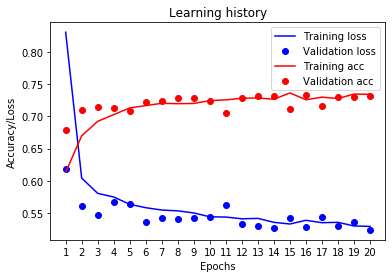

In [296]:
loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Learning history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

In [317]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_standard.drop(['acc_id', 
                                                                           'amount_spent_y',
                                                                           'total_spent',
                                                                          'secession',
                                                                          'survival_time'], axis=1),
                                                    merge_standard.survival_time,
                                                    test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 400), (7000, 400), (12000, 400), (21000,), (7000,), (12000,))

In [406]:
import tensorflow as tf
from keras import models
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

np.random.seed(42)
tf.random.set_random_seed(42)

X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train).reshape(-1,1)
Y_train = np_utils.to_categorical(y_train_arr, 65)

X_valid_arr = np.array(X_valid)
y_valid_arr = np.array(y_valid).reshape(-1,1)
Y_valid = np_utils.to_categorical(y_valid_arr, 65)

# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = Sequential()
model.add(Dense(1024, activation = 'relu', kernel_initializer='he_uniform', input_shape=(400,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', kernel_initializer='he_uniform'))
# # # model.add(Dropout(0.2))
# model.add(Dense(256, activation = 'relu', kernel_initializer='he_uniform'))
# # # model.add(Dropout(0.2))
# model.add(Dense(128, activation = 'relu', kernel_initializer='he_uniform'))
# # # model.add(Dropout(0.2))
# model.add(Dense(128, activation = 'relu', kernel_initializer='he_uniform'))
# # model.add(Dropout(0.2))
# model.add(Dense(1024, activation = 'relu', kernel_initializer='he_uniform'))
# # model.add(Dropout(0.2))
# model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform'))
# # model.add(Dropout(0.2))
model.add(Dense(65, activation = 'softmax'))


model.compile(optimizer = 'adadelta',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit(X_train,
                   Y_train,
                   epochs = 20,
                   batch_size = 300,
                   validation_data = (X_valid, Y_valid))

Train on 21000 samples, validate on 7000 samples
Epoch 1/20
21000/21000 [==============================] - 40s 2ms/step - loss: 2.4995 - acc: 0.5472 - val_loss: 2.1539 - val_acc: 0.5739
Epoch 2/20
21000/21000 [==============================] - 13s 637us/step - loss: 2.2179 - acc: 0.5697 - val_loss: 2.2123 - val_acc: 0.5827 acc: 0. - ETA: 2s - loss: 2.231
Epoch 3/20
21000/21000 [==============================] - 13s 621us/step - loss: 2.1485 - acc: 0.5777 - val_loss: 2.1198 - val_acc: 0.5940
Epoch 4/20
21000/21000 [==============================] - 13s 620us/step - loss: 2.0895 - acc: 0.5812 - val_loss: 2.1166 - val_acc: 0.5941
Epoch 5/20
21000/21000 [==============================] - 13s 622us/step - loss: 2.0501 - acc: 0.5851 - val_loss: 2.0726 - val_acc: 0.5929
Epoch 6/20
21000/21000 [==============================] - 13s 622us/step - loss: 2.0044 - acc: 0.5911 - val_loss: 2.0218 - val_acc: 0.5996
Epoch 7/20
21000/21000 [==============================] - 13s 624us/step - loss: 1.9663

In [407]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
accuracy_score(y_test, y_pred)

0.60775

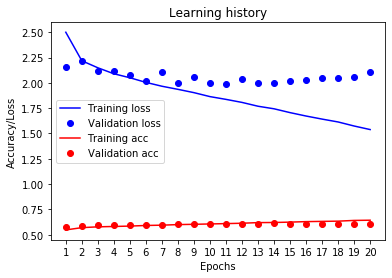

In [408]:
loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Learning history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

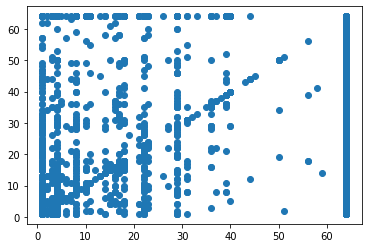

In [409]:
plt.scatter(y_pred, y_test)